In [215]:
%pip install -q matplotlib pandas scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [216]:
%config IPCompleter.greedy=True #Helps with auto-complete

import os
import requests, csv

try:
    os.mkdir('data')
except OSError as error:
    print(error)

DATA_PATH = 'data/Bitcoin.csv'

if not os.path.exists(DATA_PATH):
  url = 'https://raw.githubusercontent.com/techno-nerd/ML_Adv_Course/refs/heads/main/02%20RNNs/data/Bitcoin.csv'
  r = requests.get(url)
  with open(DATA_PATH, 'w') as f:
    writer = csv.writer(f)
    for line in r.iter_lines():
      writer.writerow(line.decode('utf-8').split(','))

[Errno 17] File exists: 'data'


In [217]:
import pandas as pd

data = pd.read_csv(DATA_PATH)

In [218]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2683 non-null   object 
 1   Open       2683 non-null   float64
 2   High       2683 non-null   float64
 3   Low        2683 non-null   float64
 4   Close      2683 non-null   float64
 5   Adj Close  2683 non-null   float64
 6   Volume     2683 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB
None


## Bitcoin Data

This dataset has daily data for Bitcoin prices and trading volumes. We will try to predict the `High` variable given the past 30 days of the highest daily price.

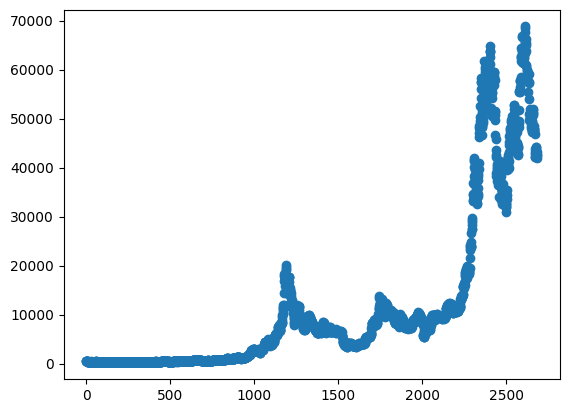

In [219]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(data.index, data['High'])
plt.show()

## Data Processing

1. Scale the values between 0 and 1. Scaling is known to improve model stability and reduce training time.
2. Extract features: Unlike normal regression, the feature is just the past data of the variable we want to predict. Therefore, we need to sample contiguous sequences from the training data 

In [220]:
from sklearn.preprocessing import MinMaxScaler

# Extract the 'High' prices as the feature
high_prices = data['High'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_high_prices = scaler.fit_transform(high_prices)

In [221]:
import numpy as np

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [222]:
SEQUENCE_LENGTH = 30 #Takes 30 days of data to predict value on 31st day

x, y = create_sequences(scaled_high_prices, SEQUENCE_LENGTH)

In [223]:
print(x.shape)
print(y.shape)

(2653, 30, 1)
(2653, 1)


In [224]:
train_size = int(len(x) * 0.8)

# Split the data
X_train, X_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [225]:
import tensorflow as tf


def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((None, 1))) #This can accept an input of variable length
    model.add(tf.keras.layers.SimpleRNN(30))
    model.add(tf.keras.layers.Dense(15, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    return model


In [226]:
rnn = build_model()
rnn.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_13 (SimpleRNN)       │ (None, 30)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

You may have noticed that the number of parameters in the `simple_rnn_1` layer are not 1550 (which would be if it were a Dense layer). 
<br></br>
That is because behind the scene, RNNs only take 1 of the values from the input sequence, and the rest of the parameters are for the hidden state. So the calculation is (1 × 50) + (50 × 50) + 50 = 2600.

In [227]:
test = np.reshape(np.array([1,2,3,4]), (-1, 1))

rnn.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


array([[0.08324889],
       [0.15673806],
       [0.2139903 ],
       [0.25312543]], dtype=float32)

As you can see, the RNN does not output one final prediction. It gives a prediction for each input (because of the final Dense layer), but these can be ignored for this problem (they are useful for other problems, like translation). So the final prediction would be `rnn.predict(test)[-1]`

In [228]:
rnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

In [229]:
rnn.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.1301
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8821e-04 - val_loss: 0.0906
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0432e-04 - val_loss: 0.0589
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4961e-05 - val_loss: 0.0467
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8397e-05 - val_loss: 0.0365
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3085e-05 - val_loss: 0.0301
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2174e-05 - val_loss: 0.0269
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1592e-05 - val_loss: 0.0219
Epoch 9/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1921e-05 - val_loss: 0.0182
Epoch 10/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4313e-05 - val_loss: 0.0163
Epoch 11/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2914e-05 - val_loss: 0.0151
Epoch 12/25
67/67 ━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model on the test set
test_loss = rnn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

scaler.inverse_transform(np.reshape([test_loss**0.5], (-1, 1))) #Scaling the loss back to the context of our data

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023     
Test Loss: 0.004172709304839373


array([[4641.62372487]])

Even though the loss appears very small, it is actually quite significant ($4641 on average). This is because RNNs struggle to capture long-term trends, and this is something that will be addressed in future lessons

In [231]:
print("Actual value on Jan 21, 2022: $", 41060.53)
predicted_value = rnn.predict(X_test[-1], verbose=0)[-1] #Using the last value to predict future
print(scaler.inverse_transform(np.reshape(predicted_value, (-1, 1))))

Actual value on Jan 21, 2022: $ 41060.53
[[26021.348]]


In [232]:
actual_future_values = [41060.53, 36688.81, 36433.31, 37247.52, 37444.57] #Data from Jan 21 2022 to Jan 25 2022 - From Yahoo Finance
last_30 = X_test[-1]

for i in range(5):
    pred = rnn.predict(last_30, verbose=0)[-1][0]
    last_30 = np.append(last_30[1:], np.reshape(pred, (1, 1)), axis=0)
    scaled_pred = scaler.inverse_transform(np.reshape(pred, (-1, 1)))
    print(f"Actual: {actual_future_values[i]}   Prediction: {scaled_pred}")

Actual: 41060.53   Prediction: [[26021.348]]
Actual: 36688.81   Prediction: [[16056.377]]
Actual: 36433.31   Prediction: [[9924.704]]
Actual: 37247.52   Prediction: [[6129.0186]]
Actual: 37444.57   Prediction: [[3808.7898]]


To save this model, you would need to save the model as a `.keras` file and the scaler as a `.pkl` file using `joblib`.